In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Herramientas de Scikit-learn
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import cross_val_score

# Para silenciar warnings
import warnings
warnings.filterwarnings('ignore')

print("Librerías importadas correctamente.")

Librerías importadas correctamente.


In [45]:
# Se usa sep=';' según la estructura de tus archivos
try:
    train_full_df = pd.read_csv("train.csv", sep=';')
    test_df = pd.read_csv("test.csv", sep=';')
    sample_submission = pd.read_csv("sample_submission.csv", sep=';') # Asumimos que también usa ';'
except FileNotFoundError:
    print("Asegúrate de tener 'train.csv', 'test.csv' y 'sample_submission.csv' en la misma carpeta.")
except Exception as e:
    print(f"Error al cargar archivos: {e}")
    print("Revisa que el separador sea ';' para todos los archivos o ajusta el código.")

print(f"Train (semanal) shape: {train_full_df.shape}")
print(f"Test (agregado) shape: {test_df.shape}")

Train (semanal) shape: (95339, 33)
Test (agregado) shape: (2250, 33)


In [46]:
print("Agregando el set de entrenamiento...")

# 1. Definir el target: 'Production' (NO 'demand')
# El problema pide predecir la cantidad de producción óptima
target_agg = {'weekly_demand': 'sum', 'Production': 'first'}

# 2. Definir las features estáticas
static_cols = [
    'id_season', 'aggregated_family', 'family', 'category', 'fabric', 'color_name',
    'image_embedding',
    'length_type', 'silhouette_type', 'waist_type',
    'neck_lapel_type', 'sleeve_length_type', 'heel_shape_type', 'toecap_type',
    'woven_structure', 'knit_structure', 'print_type', 'archetype', 'moment', 'ocassion',
    'life_cycle_length', 'num_stores', 'num_sizes',
    'has_plus_sizes', 'price', 'phase_in', 'phase_out'
]

# Creamos un diccionario de agregación
features_agg = {col: 'first' for col in static_cols if col in train_full_df.columns}

# 3. Combinar las reglas de agregación
agg_rules = {**target_agg, **features_agg}

# 4. Ejecutar la agregación
train_agg_df = train_full_df.groupby('ID').agg(agg_rules).reset_index()

# Renombrar demanda total
train_agg_df.rename(columns={'weekly_demand': 'total_demand'}, inplace=True)

# 5. Crear features temporales y de demanda
# Ratio demanda/producción
train_agg_df['demand_prod_ratio'] = train_agg_df['total_demand'] / (train_agg_df['Production'] + 1)
train_agg_df['stockout_risk'] = (train_agg_df['total_demand'] > train_agg_df['Production']).astype(int)
train_agg_df['overstock_risk'] = (train_agg_df['Production'] > train_agg_df['total_demand'] * 1.5).astype(int)

# Features de precio
train_agg_df['price_per_store'] = train_agg_df['price'] / (train_agg_df['num_stores'] + 1)
train_agg_df['price_per_size'] = train_agg_df['price'] / (train_agg_df['num_sizes'] + 1)

# Features de ciclo de vida
train_agg_df['demand_per_week'] = train_agg_df['total_demand'] / (train_agg_df['life_cycle_length'] + 1)
train_agg_df['demand_per_store'] = train_agg_df['total_demand'] / (train_agg_df['num_stores'] + 1)

print(f"Nuevo train (agregado) shape: {train_agg_df.shape}")
print(f"\\nTarget to predict: Production")
print(f"Estadísticas de Production vs Demand:")
print(train_agg_df[['Production', 'total_demand', 'demand_prod_ratio']].describe())

Agregando el set de entrenamiento...
Nuevo train (agregado) shape: (9843, 36)
\nTarget to predict: Production
Estadísticas de Production vs Demand:
          Production   total_demand  demand_prod_ratio
count    9843.000000    9843.000000        9843.000000
mean    24752.955603   10820.920349           0.378390
std     26828.148807   16070.932711           0.232843
min        90.000000      19.000000           0.050863
25%      6853.500000    1660.000000           0.202794
50%     18152.000000    5230.000000           0.338533
75%     33250.000000   14106.000000           0.505813
max    403172.000000  251724.000000           3.557507


In [47]:
print("Procesando image embeddings y creando features k-NN...")

# ¡FUNCIÓN CORREGIDA Y MÁS ROBUSTA!
def parse_embedding(embedding_str):
    if pd.isna(embedding_str) or embedding_str == "":
        return None
    try:
        # Usamos split(',') para crear una lista de strings y luego
        # la convertimos en un array de números.
        return np.array(embedding_str.split(','), dtype=np.float32)
    except Exception as e:
        #print(f"Error parseando embedding: {e}") # Descomentar para debug
        return None

# Aplicar la función a train y test
train_agg_df['emb_array'] = train_agg_df['image_embedding'].apply(parse_embedding)
test_df['emb_array'] = test_df['image_embedding'].apply(parse_embedding)

# --- De aquí en adelante, el código es el mismo ---

# Asumimos que el embedding tiene 256 dimensiones basado en el ejemplo largo.
# El código intentará auto-detectarlo de todas formas.
EMBEDDING_DIM = 256 # Estimación inicial
try:
    # Intenta encontrar la dimensión automáticamente del primer item válido
    first_valid_emb = train_agg_df['emb_array'].dropna().iloc[0]
    EMBEDDING_DIM = len(first_valid_emb)
    print(f"Dimensión del embedding detectada: {EMBEDDING_DIM}")
except IndexError:
    print(f"No se pudo detectar la dimensión del embedding, se usará {EMBEDDING_DIM}.")
    print("Asegúrate de que al menos un embedding se parseó correctamente.")
    
default_emb = np.zeros(EMBEDDING_DIM)

# Rellenar Nones con el array de ceros
train_embeddings_list = train_agg_df['emb_array'].apply(lambda x: x if x is not None else default_emb).tolist()
test_embeddings_list = test_df['emb_array'].apply(lambda x: x if x is not None else default_emb).tolist()

# ¡¡CAMBIO CLAVE!! Usamos np.stack() sobre una lista, que es más seguro que np.vstack()
try:
    X_emb_train = np.stack(train_embeddings_list)
    X_emb_test = np.stack(test_embeddings_list)
except ValueError as e:
    print(f"¡Error al apilar arrays! {e}")
    print("Esto suele pasar si no todos los embeddings tienen la misma longitud.")
    print(f"Longitud esperada: {EMBEDDING_DIM}")
    # Opcional: imprimir longitudes para debug
    # for i, emb in enumerate(train_embeddings_list):
    #     if len(emb) != EMBEDDING_DIM:
    #         print(f"Train Fila {i} tiene longitud {len(emb)}")


# Entrenar modelo k-NN
knn = NearestNeighbors(n_neighbors=6, metric='cosine', algorithm='brute')
knn.fit(X_emb_train)

# --- Crear features para el set de TEST ---
distances, indices = knn.kneighbors(X_emb_test, n_neighbors=5) # 5 vecinos
# CORRECCIÓN: Iterar sobre cada fila de vecinos
test_knn_mean_demand = []
test_knn_mean_production = []
for neighbor_indices in indices:
    test_knn_mean_demand.append(train_agg_df.iloc[neighbor_indices]['total_demand'].mean())
    test_knn_mean_production.append(train_agg_df.iloc[neighbor_indices]['Production'].mean())

test_df['knn_mean_demand'] = test_knn_mean_demand
test_df['knn_mean_production'] = test_knn_mean_production

# --- Crear features para el set de TRAIN (para validación) ---
distances, indices = knn.kneighbors(X_emb_train, n_neighbors=6) # 6 vecinos (él mismo + 5)
indices_sin_self = indices[:, 1:] # Quitar el primer vecino (él mismo)
# CORRECCIÓN: Iterar sobre cada fila de vecinos
train_knn_mean_demand = []
train_knn_mean_production = []
for neighbor_indices in indices_sin_self:
    train_knn_mean_demand.append(train_agg_df.iloc[neighbor_indices]['total_demand'].mean())
    train_knn_mean_production.append(train_agg_df.iloc[neighbor_indices]['Production'].mean())

train_agg_df['knn_mean_demand'] = train_knn_mean_demand
train_agg_df['knn_mean_production'] = train_knn_mean_production

print("Features k-NN creadas para train y test.")

Procesando image embeddings y creando features k-NN...
Dimensión del embedding detectada: 512
Dimensión del embedding detectada: 512
Features k-NN creadas para train y test.
Features k-NN creadas para train y test.


In [48]:
# CAMBIO CRÍTICO: El target es Production, no total_demand
TARGET = 'Production'

# Definir qué columnas son categóricas y cuáles numéricas
categorical_features = [
    'aggregated_family', 'family', 'category', 'fabric', 'color_name',
    'length_type', 'silhouette_type', 'waist_type', 'neck_lapel_type',
    'sleeve_length_type', 'heel_shape_type', 'toecap_type', 'woven_structure',
    'knit_structure', 'print_type', 'archetype', 'moment', 'ocassion',
    'has_plus_sizes'
]

numerical_features = [
    'life_cycle_length', 'num_stores', 'num_sizes', 'price',
    'total_demand',  # La demanda total es una feature muy importante
    'demand_prod_ratio', 'stockout_risk', 'overstock_risk',
    'price_per_store', 'price_per_size', 'demand_per_week', 'demand_per_store',
    'knn_mean_demand', 'knn_mean_production'
]

# Asegurarnos de que todas las columnas existen
categorical_features = [col for col in categorical_features if col in train_agg_df.columns]
numerical_features = [col for col in numerical_features if col in train_agg_df.columns]

print(f"Features numéricas ({len(numerical_features)}): {numerical_features}")
print(f"\\nFeatures categóricas ({len(categorical_features)}): {categorical_features}")

# --- Split de Validación Temporal ---
seasons = sorted(train_agg_df['id_season'].unique())
validation_season = seasons[-1] 
train_seasons = seasons[:-1]

print(f"\\nTemporadas de entrenamiento: {train_seasons}")
print(f"Temporada de validación: {validation_season}")

# Crear los sets
train_mask = train_agg_df['id_season'].isin(train_seasons)
val_mask = train_agg_df['id_season'] == validation_season

X_train = train_agg_df[train_mask][numerical_features + categorical_features]
y_train = train_agg_df[train_mask][TARGET]

X_val = train_agg_df[val_mask][numerical_features + categorical_features]
y_val = train_agg_df[val_mask][TARGET]

print(f"\\nX_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"\\nTarget distribution in training:")
print(y_train.describe())

Features numéricas (14): ['life_cycle_length', 'num_stores', 'num_sizes', 'price', 'total_demand', 'demand_prod_ratio', 'stockout_risk', 'overstock_risk', 'price_per_store', 'price_per_size', 'demand_per_week', 'demand_per_store', 'knn_mean_demand', 'knn_mean_production']
\nFeatures categóricas (18): ['aggregated_family', 'family', 'category', 'fabric', 'color_name', 'length_type', 'silhouette_type', 'waist_type', 'neck_lapel_type', 'sleeve_length_type', 'heel_shape_type', 'toecap_type', 'woven_structure', 'knit_structure', 'print_type', 'archetype', 'moment', 'has_plus_sizes']
\nTemporadas de entrenamiento: [np.int64(86), np.int64(87), np.int64(88)]
Temporada de validación: 89
\nX_train shape: (7307, 32)
X_val shape: (2536, 32)
\nTarget distribution in training:
count      7307.000000
mean      24665.675106
std       27033.652940
min          90.000000
25%        6471.000000
50%       17663.000000
75%       33563.000000
max      403172.000000
Name: Production, dtype: float64


In [49]:
# 1. Pipeline para features numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Pipeline para features categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# 3. Combinar los pipelines con ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Pipeline de preprocesamiento creado.")

Pipeline de preprocesamiento creado.


In [50]:
# Para MAE, usamos regresión estándar (no cuantílica)
# MAE se minimiza prediciendo la mediana, pero queremos un modelo robusto

# Modelo 1: HistGradientBoostingRegressor con MAE loss
model_hgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', HistGradientBoostingRegressor(
        loss='absolute_error',  # Optimiza directamente para MAE
        max_iter=200,
        learning_rate=0.05,
        max_depth=8,
        min_samples_leaf=20,
        random_state=42
    ))
])

print(f"Pipeline de modelo creado con HistGradientBoosting (MAE loss).")

Pipeline de modelo creado con HistGradientBoosting (MAE loss).


Entrenando el modelo...
--- Evaluación en Set de Validación (Temporada 5) ---
Error Absoluto Medio (MAE): 1405.39
R^2 Score: 0.9415
\nEstadísticas de las predicciones:
Media predicha: 24572.26
Media real: 25004.44
Min predicho: 160.78, Max predicho: 193471.74
\nErrores por categoría:
                                            mean  count
category                                               
Tops                                 1867.018079   1002
Bottoms                              1405.677048    651
Outerwear                            1024.174661    358
Dresses, jumpsuits and Complete set   819.206506    488
Accesories, Swim and Intimate         318.722890     37
--- Evaluación en Set de Validación (Temporada 5) ---
Error Absoluto Medio (MAE): 1405.39
R^2 Score: 0.9415
\nEstadísticas de las predicciones:
Media predicha: 24572.26
Media real: 25004.44
Min predicho: 160.78, Max predicho: 193471.74
\nErrores por categoría:
                                            mean  count
catego

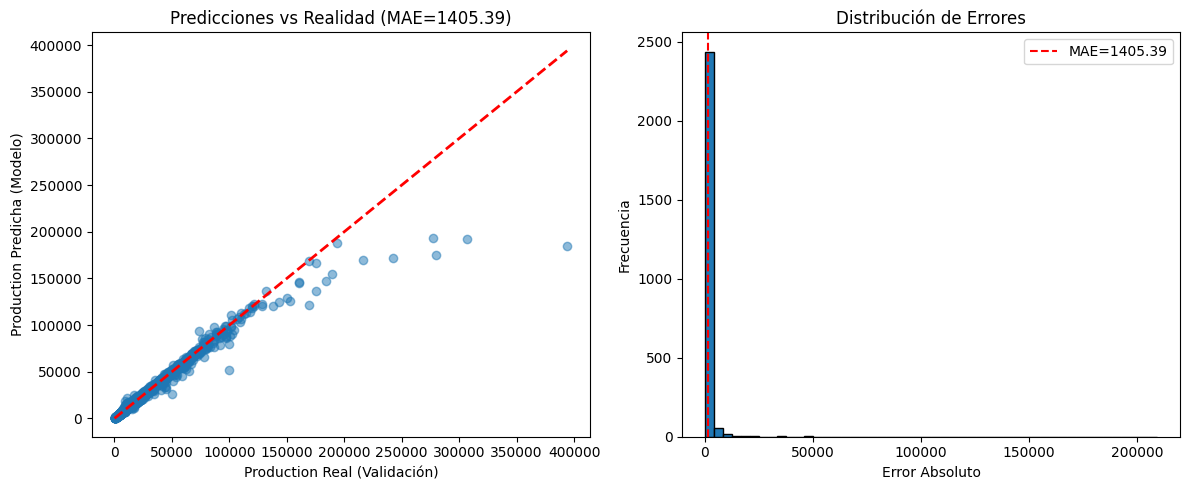

In [51]:
print("Entrenando el modelo...")
model_hgb.fit(X_train, y_train)

# Predecir en el set de validación
val_preds = model_hgb.predict(X_val)

# Asegurarse de que no haya predicciones negativas
val_preds[val_preds < 0] = 0

# Evaluar
mae = mean_absolute_error(y_val, val_preds)
r2 = r2_score(y_val, val_preds)

print("--- Evaluación en Set de Validación (Temporada 5) ---")
print(f"Error Absoluto Medio (MAE): {mae:.2f}")
print(f"R^2 Score: {r2:.4f}")
print(f"\\nEstadísticas de las predicciones:")
print(f"Media predicha: {val_preds.mean():.2f}")
print(f"Media real: {y_val.mean():.2f}")
print(f"Min predicho: {val_preds.min():.2f}, Max predicho: {val_preds.max():.2f}")

# Analizar errores por categorías
val_df_analysis = train_agg_df[val_mask].copy()
val_df_analysis['predicted_production'] = val_preds
val_df_analysis['actual_production'] = y_val.values
val_df_analysis['abs_error'] = np.abs(val_df_analysis['predicted_production'] - val_df_analysis['actual_production'])

print(f"\\nErrores por categoría:")
error_by_category = val_df_analysis.groupby('category')['abs_error'].agg(['mean', 'count'])
print(error_by_category.sort_values('mean', ascending=False).head(10))

# Visualización
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_val, val_preds, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--', color='red', lw=2)
plt.xlabel("Production Real (Validación)")
plt.ylabel("Production Predicha (Modelo)")
plt.title(f"Predicciones vs Realidad (MAE={mae:.2f})")

plt.subplot(1, 2, 2)
plt.hist(val_df_analysis['abs_error'], bins=50, edgecolor='black')
plt.xlabel("Error Absoluto")
plt.ylabel("Frecuencia")
plt.title("Distribución de Errores")
plt.axvline(mae, color='red', linestyle='--', label=f'MAE={mae:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

Entrenando modelo final con TODOS los datos de train...
Prediciendo en el test set...
\nArchivo 'submission_improved.csv' generado exitosamente.
\nPrimeras predicciones:
    ID  Production
0   90        3162
1   16       11220
2   65       14474
3  138        2277
4  166        1533
5  252       19597
6  234       15007
7  306       14815
8  274       20453
9  268        1339
\nEstadísticas de predicciones:
Media: 10984.20
Mediana: 11804.50
Min: 1126, Max: 23988
Prediciendo en el test set...
\nArchivo 'submission_improved.csv' generado exitosamente.
\nPrimeras predicciones:
    ID  Production
0   90        3162
1   16       11220
2   65       14474
3  138        2277
4  166        1533
5  252       19597
6  234       15007
7  306       14815
8  274       20453
9  268        1339
\nEstadísticas de predicciones:
Media: 10984.20
Mediana: 11804.50
Min: 1126, Max: 23988


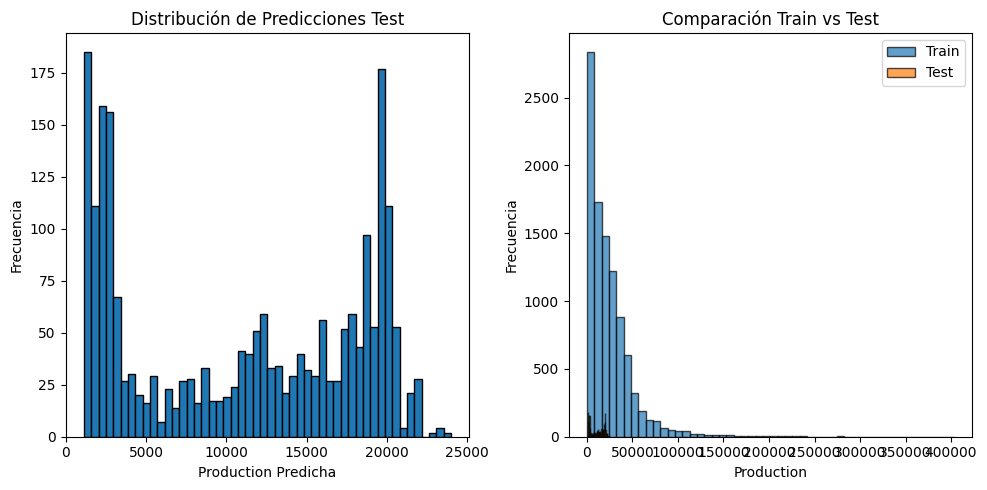

In [52]:
print("Entrenando modelo final con TODOS los datos de train...")

# Definimos el X e y finales
X_full_train = train_agg_df[numerical_features + categorical_features]
y_full_train = train_agg_df[TARGET]

# Entrenamos el pipeline final
final_model_pipeline = model_hgb.fit(X_full_train, y_full_train)

print("Prediciendo en el test set...")

# Preparar test set con las mismas features
test_df['total_demand'] = 0  # No tenemos demanda real, usamos 0 o estimación
test_df['demand_prod_ratio'] = 0
test_df['stockout_risk'] = 0
test_df['overstock_risk'] = 0
test_df['price_per_store'] = test_df['price'] / (test_df['num_stores'] + 1)
test_df['price_per_size'] = test_df['price'] / (test_df['num_sizes'] + 1)
test_df['demand_per_week'] = 0
test_df['demand_per_store'] = 0

# Predecir
test_preds = final_model_pipeline.predict(test_df[numerical_features + categorical_features])

# Asegurar que no haya predicciones negativas y redondear
test_preds[test_preds < 0] = 0
test_preds = np.round(test_preds).astype(int)

# CRÍTICO: El formato de submission es "ID,Production"
submission_df = pd.DataFrame({
    'ID': test_df['ID'],
    'Production': test_preds
})

# Guardar con el formato correcto (coma como separador, como pide sample_submission)
submission_df.to_csv('submission_improved.csv', index=False, sep=',')
print("\\nArchivo 'submission_improved.csv' generado exitosamente.")
print("\\nPrimeras predicciones:")
print(submission_df.head(10))
print(f"\\nEstadísticas de predicciones:")
print(f"Media: {test_preds.mean():.2f}")
print(f"Mediana: {np.median(test_preds):.2f}")
print(f"Min: {test_preds.min()}, Max: {test_preds.max()}")

# Análisis de distribución
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(test_preds, bins=50, edgecolor='black')
plt.xlabel('Production Predicha')
plt.ylabel('Frecuencia')
plt.title('Distribución de Predicciones Test')

plt.subplot(1, 2, 2)
plt.hist(y_full_train, bins=50, edgecolor='black', alpha=0.7, label='Train')
plt.hist(test_preds, bins=50, edgecolor='black', alpha=0.7, label='Test')
plt.xlabel('Production')
plt.ylabel('Frecuencia')
plt.title('Comparación Train vs Test')
plt.legend()
plt.tight_layout()
plt.show()

## Mejora Adicional: Modelo Ensemble

Vamos a crear un ensemble de múltiples modelos para mejorar aún más las predicciones.

In [53]:
print("Creando modelo ensemble...")

# Modelo 2: RandomForest
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_leaf=10,
        random_state=42,
        n_jobs=-1
    ))
])

# Modelo 3: HGB con hiperparámetros diferentes
model_hgb2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', HistGradientBoostingRegressor(
        loss='absolute_error',
        max_iter=300,
        learning_rate=0.03,
        max_depth=10,
        min_samples_leaf=15,
        random_state=123
    ))
])

# Entrenar todos los modelos
print("Entrenando modelo 1 (HGB original)...")
model_hgb.fit(X_train, y_train)

print("Entrenando modelo 2 (RandomForest)...")
model_rf.fit(X_train, y_train)

print("Entrenando modelo 3 (HGB variante)...")
model_hgb2.fit(X_train, y_train)

# Predicciones en validación
pred1 = model_hgb.predict(X_val)
pred2 = model_rf.predict(X_val)
pred3 = model_hgb2.predict(X_val)

# Ensemble: promedio ponderado
ensemble_pred = 0.4 * pred1 + 0.3 * pred2 + 0.3 * pred3
ensemble_pred[ensemble_pred < 0] = 0

# Evaluar cada modelo
mae1 = mean_absolute_error(y_val, np.maximum(pred1, 0))
mae2 = mean_absolute_error(y_val, np.maximum(pred2, 0))
mae3 = mean_absolute_error(y_val, np.maximum(pred3, 0))
mae_ensemble = mean_absolute_error(y_val, ensemble_pred)

print("\\n--- Comparación de Modelos en Validación ---")
print(f"Modelo 1 (HGB):          MAE = {mae1:.2f}")
print(f"Modelo 2 (RF):           MAE = {mae2:.2f}")
print(f"Modelo 3 (HGB variant):  MAE = {mae3:.2f}")
print(f"Ensemble (ponderado):    MAE = {mae_ensemble:.2f}")
print(f"\\n¡Mejora con ensemble: {mae1 - mae_ensemble:.2f} puntos de MAE!")

# Entrenar en todo el dataset
print("\\nEntrenando modelos finales con todos los datos...")
model_hgb.fit(X_full_train, y_full_train)
model_rf.fit(X_full_train, y_full_train)
model_hgb2.fit(X_full_train, y_full_train)

# Predicciones finales en test
test_pred1 = model_hgb.predict(test_df[numerical_features + categorical_features])
test_pred2 = model_rf.predict(test_df[numerical_features + categorical_features])
test_pred3 = model_hgb2.predict(test_df[numerical_features + categorical_features])

# Ensemble final
final_ensemble_pred = 0.4 * test_pred1 + 0.3 * test_pred2 + 0.3 * test_pred3
final_ensemble_pred[final_ensemble_pred < 0] = 0
final_ensemble_pred = np.round(final_ensemble_pred).astype(int)

# Crear submission
submission_ensemble = pd.DataFrame({
    'ID': test_df['ID'],
    'Production': final_ensemble_pred
})

submission_ensemble.to_csv('submission_ensemble_final.csv', index=False, sep=',')
print("\\n✓ Archivo 'submission_ensemble_final.csv' generado exitosamente.")
print("\\nPrimeras predicciones del ensemble:")
print(submission_ensemble.head(10))
print(f"\\nEstadísticas finales:")
print(f"Media: {final_ensemble_pred.mean():.2f}")
print(f"Mediana: {np.median(final_ensemble_pred):.2f}")
print(f"Min: {final_ensemble_pred.min()}, Max: {final_ensemble_pred.max()}")

Creando modelo ensemble...
Entrenando modelo 1 (HGB original)...
Entrenando modelo 2 (RandomForest)...
Entrenando modelo 2 (RandomForest)...
Entrenando modelo 3 (HGB variante)...
Entrenando modelo 3 (HGB variante)...
\n--- Comparación de Modelos en Validación ---
Modelo 1 (HGB):          MAE = 1405.39
Modelo 2 (RF):           MAE = 1697.41
Modelo 3 (HGB variant):  MAE = 1434.41
Ensemble (ponderado):    MAE = 1367.34
\n¡Mejora con ensemble: 38.05 puntos de MAE!
\nEntrenando modelos finales con todos los datos...
\n--- Comparación de Modelos en Validación ---
Modelo 1 (HGB):          MAE = 1405.39
Modelo 2 (RF):           MAE = 1697.41
Modelo 3 (HGB variant):  MAE = 1434.41
Ensemble (ponderado):    MAE = 1367.34
\n¡Mejora con ensemble: 38.05 puntos de MAE!
\nEntrenando modelos finales con todos los datos...
\n✓ Archivo 'submission_ensemble_final.csv' generado exitosamente.
\nPrimeras predicciones del ensemble:
    ID  Production
0   90        3527
1   16       12559
2   65       17490
3 